### Machine Learning Decision Making

For this work, we will be using a dataset from the Kaggle site that contains information on various factors of heart disease. We will be building a Random Forest classifier to predict if a person is to be suffering from heart disease and conduct a deeper investigation into the model's decision making.

### Code

In [193]:
# Import libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [195]:
# Load data
df = pd.read_csv('heart.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      1

It appears that this dataset has 303 entries of patient data and 14 columns:
- `age`: Age (numerical)
- `sex`: Gender (categorical)
- `cp`: CP level (categorical)
- `trestbps`: Trest BPS level (numerical)
- `chol`: Cholesterol level (numerical)
- `fbs`: FBS level (categorical)
- `restecg`: Resting ECG level (categorical)
- `thalach`: Thalach level (numerical)
- `exang`: Exang level (categorical)
- `oldpeak`: Old peak history recorded (numerical)
- `slope`: Slope level (categorical)
- `ca`: CA level (categorical)
- `thal`: Thal level (categorical)
- `target`: Presence of heart disease (0 = Healthy, 1 = Heart Disease)

Let's check for any missing values in the dataset.

In [198]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Perfect - don't need to worry about any missing values to handle. For this binary classification problem, I will be leveraging a Random Forest model. So, let's build it and evaluate its initial performance. 

In [200]:
# Split features from target variable
X = df.drop('target', axis=1)
y = df['target']

In [201]:
# One hot encode categorical columns and split into train/test sets
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [202]:
# Train RF classifier and generate predictions
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [203]:
# Check out performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[19  9]
 [ 1 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61

Accuracy: 0.8360655737704918


Not that it really matters for this, but this initial iteration of the Random Forest classifier yielded an accuracy rate of about 84%. This is definitely more interesting than if we produced a model succeeding in predicting (something like) 99% of patients.

### Local Explanation - High Risk Prediction

We will be using LIME to investigate the model's first prediction of the test set (Entry 0).

In [207]:
# Generate explanation for instance 0
instance = X_test.iloc[0]
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    mode='classification',
    discretize_continuous=True
)
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=clf.predict_proba,
    num_features=10
)
exp.show_in_notebook(show_table=True)

For this entry, our Random Forest classifier predicted a Class 0 with a confidence of 0.82, which means this patient does not suffer from heart disease. The two most influential features are `cp` and `thal`, which have respective weights of 0.20 and 0.17. Because the `cp` value for this entry met the model's criteria of being less than or equal to 0, it contributed 0.20 to push the model to predict the patient did not have heart disease. The `thal` value for this entry met the model's criteria of being less than or equal to 2, so it contributed 0.17 to push the model to predict the patient did suffer from heart disease. Ultimately, there ended up being more features that pushed the model to predict Class 0 over Class 1 for this entry.

### Global Understanding - Important Features

To analyze the top contributing features across the dataset, we can use a SHAP summary plot.

In [211]:
# Generate SHAP plot
shap_explainer = shap.Explainer(clf, X_train)
shap_values = shap_explainer(X_train)
print("SHAP values shape:", shap_values.values.shape)

SHAP values shape: (242, 13, 2)


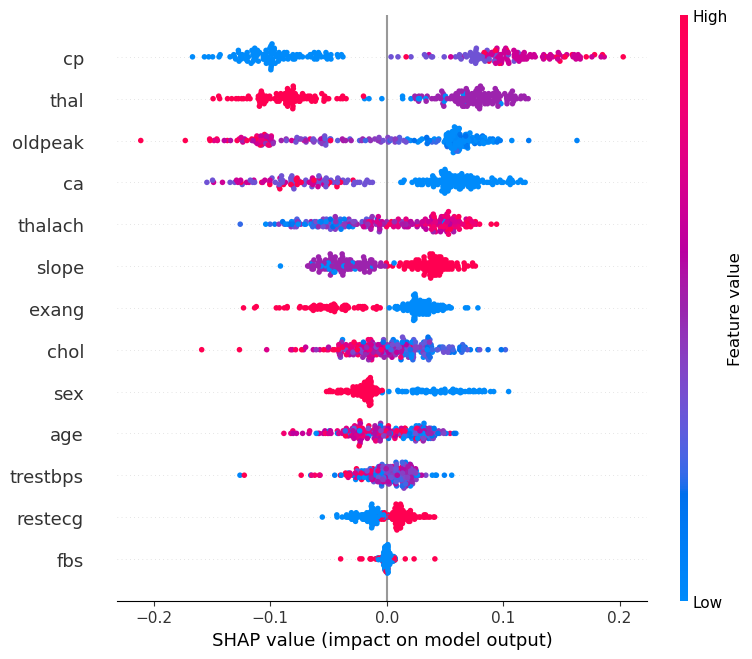

<Figure size 640x480 with 0 Axes>

In [212]:
# Plot SHAP values for Class 1 predictions
shap_values_class1 = shap_values.values[:, :, 1]
shap.summary_plot(shap_values_class1, X_train)
plt.tight_layout()
plt.show()

This plot represents the SHAP values for the patients that were predicted to have heart disease. The blue color represents a lower feature values, while the red color represents a higher feature value. The features are listed in order of decreasing importance. So, `cp`, `thal`, and `oldpeak` were the most influential, while `restecg` and `fbs` were not seen as very important. For the `cp` feature, we can see that the left side consists of only blue dots. This indicates that lower `cp` levels push the model to generate a Class 0 prediction, which represents a lack of heart disease. The red dots for the `cp` feature appear to be strictly on the right side of the plot, which indicates higher `cp` levels encourage the model to generate a Class 1 prediction.

### Fairness Audit - Sensitive Attributes

Because `cp` appears to be the most influential one in this dataset, let's investigate it a little further. We can analyze if the impact of this feature differs by subgroup, like gender, which could potentially indicate bias.

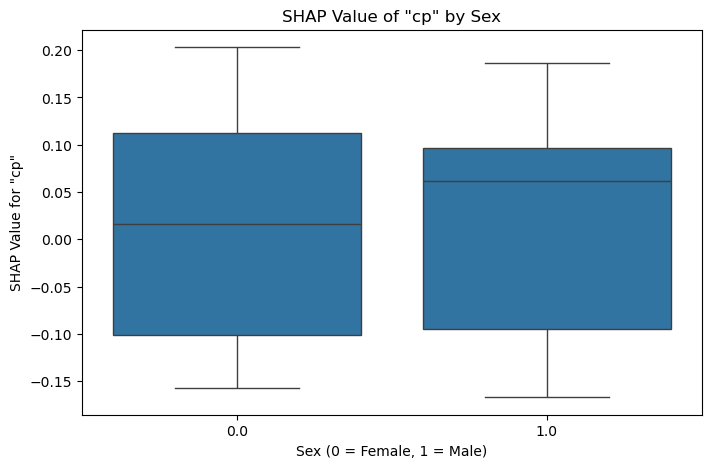

Mean SHAP value for 'cp' by sex:
sex
0.0    0.009779
1.0    0.011582
Name: cp, dtype: float64
T-test result: t = 0.108, p = 0.9141


In [216]:
# Plot cp SHAP values across different genders
shap_df = pd.DataFrame(shap_values_class1, columns=X_train.columns)
shap_df['sex'] = X_train['sex']
plt.figure(figsize=(8, 5))
sns.boxplot(x='sex', y='cp', data=shap_df)
plt.title('SHAP Value of "cp" by Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('SHAP Value for "cp"')
plt.show()

group_means = shap_df.groupby('sex')['cp'].mean()
print("Mean SHAP value for 'cp' by sex:")
print(group_means)

male_cp = shap_df[shap_df['sex'] == 1]['cp']
female_cp = shap_df[shap_df['sex'] == 0]['cp']
t_stat, p_val = ttest_ind(male_cp, female_cp, equal_var=False)
print(f"T-test result: t = {t_stat:.3f}, p = {p_val:.4f}")

In our dataset, a `sex` value of 0 indicates a female and a value of 1 represents a male. For the females, the average SHAP value is 0.0098, while the average SHAP value for the males is 0.0116. This does not seem to be a large enough difference to suggest the model is treating `cp` values differently depending on sex. Also, a resulting t-test for this feature yielded a very high p-value of 0.91. This is further confirmation that this different in average SHAP value across the different genders is not statistically significant. This was kind of boring, so let's check out the next most influential feature - `thal`. 

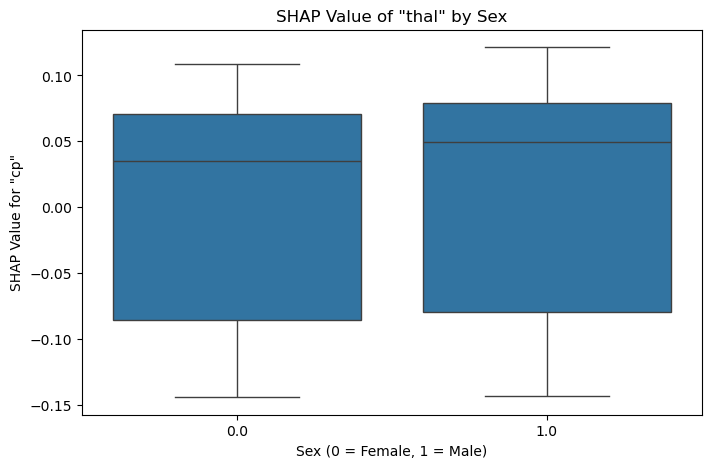

Mean SHAP value for 'thal' by sex:
sex
0.0    0.001106
1.0    0.010733
Name: thal, dtype: float64
T-test result: t = 0.785, p = 0.4336


In [218]:
# Plot thal SHAP values across different genders
plt.figure(figsize=(8, 5))
sns.boxplot(x='sex', y='thal', data=shap_df)
plt.title('SHAP Value of "thal" by Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('SHAP Value for "cp"')
plt.show()

group_means = shap_df.groupby('sex')['thal'].mean()
print("Mean SHAP value for 'thal' by sex:")
print(group_means)

male_cp = shap_df[shap_df['sex'] == 1]['thal']
female_cp = shap_df[shap_df['sex'] == 0]['thal']
t_stat, p_val = ttest_ind(male_cp, female_cp, equal_var=False)
print(f"T-test result: t = {t_stat:.3f}, p = {p_val:.4f}")

For the females, the average `thal` SHAP value is 0.0011, while the average `thal` SHAP value for the males is 0.0107. This does seem to be a moderate difference, but a resulting t-test for this feature yielded a very high p-value of 0.43. This suggests the model is treating the `thal` values the same - no matter the gender.

### Counterfactual Analysis

To analyze what changes would shift the model's prediction to the opposite class, we can use a waterfall plot. Let's look at the third entry (randomly chosen).

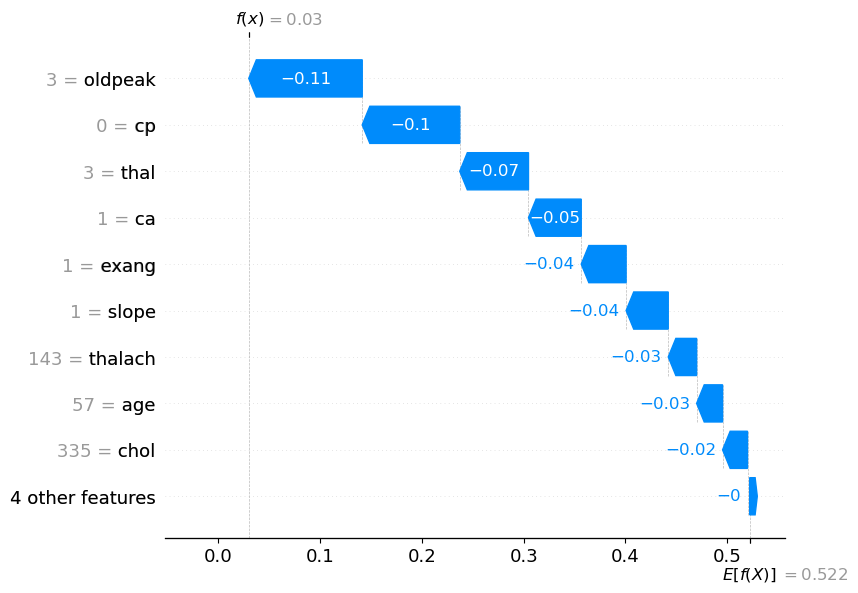

In [242]:
# Waterfall plot for third entry
i = 3
values = shap_values_class1[i]                
data = X_train.iloc[i].values                 
base_value = shap_explainer.expected_value[1] 
feature_names = X_train.columns.tolist()
explanation = shap.Explanation(
    values=values,
    base_values=base_value,
    data=data,
    feature_names=feature_names
)
shap.plots.waterfall(explanation)

This waterfall plot shows us that the base value the model starts at is 0.522 and each feature impacts this score in a certain direction. For this specific entry, the accumulation of feature impacts decreased this value all the way to 0.03, which would culminate in a Class 0 prediction. The `oldpeak` feature supplied the biggest impact on this value with a subtraction of 0.11. Just for fun, we can simulate how changing this entry's value for the `cp` feature may affect the model's prediction for this same entry. We will change it from 0 to 1. 

In [245]:
# Change cp value and check feature impacts on prediction
i = 3
original_instance = X_train.iloc[i].copy()
original_pred = clf.predict_proba([original_instance])[0, 1]
print("Original f(x):", original_pred)
modified_instance = original_instance.copy()
modified_instance['cp'] = 1
modified_pred = clf.predict_proba([modified_instance])[0, 1]
print("Modified f(x):", modified_pred)
print("Change in prediction:", modified_pred - original_pred)

Original f(x): 0.03
Modified f(x): 0.2
Change in prediction: 0.17


Changing the `cp` value from 0 to 1 had a pretty decent affect on the model's prediction. It would still result in a Class 0 prediction, but the resulting value jumped up from 0.03 to 0.20.

### Model Trust and Explanation Fidelity

Let's apply LIME and SHAP to entry 5 to view how the results may differ.

In [261]:
shap_values_class1[5]

array([ 0.00868107, -0.01923036, -0.04171071,  0.00292643,  0.03514667,
       -0.00123119, -0.00870274, -0.01809714,  0.04155381, -0.05439821,
        0.07376226,  0.09041131,  0.06848881])

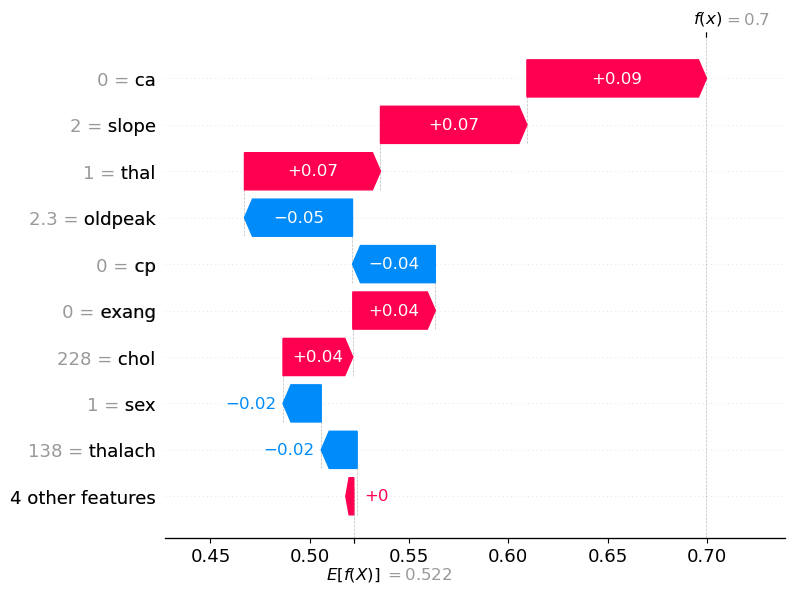

In [249]:
# Waterfall plot for fifth entry
i = 5
values = shap_values_class1[i]                
data = X_train.iloc[i].values                 
base_value = shap_explainer.expected_value[1] 
feature_names = X_train.columns.tolist()
explanation = shap.Explanation(
    values=values,
    base_values=base_value,
    data=data,
    feature_names=feature_names
)
shap.plots.waterfall(explanation)

In [263]:
# Generate LIME explanation for instance 5
instance = X_train.iloc[5]
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    mode='classification',
    discretize_continuous=True
)
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=clf.predict_proba,
    num_features=10
)
exp.show_in_notebook(show_table=True)

Right off the bat, both of these explanations indicate a Class 1 prediction with a probability of 0.70. Not sure if that is supposed to happen or just pure coincidence they ended up producing same confidence value. Both methods appear to view each feature similarily in regards to the direction they push the model's direction to. However, they do weigh the features a little bit differently. SHAP has the `thal` feature contributing only 0.07 to pushing the model towards a Class 1 prediction, while LIME has the `thal` feature contributing 0.17 to pushing the model towards a Class 1 prediction. Across the board, it seems like LIME has bigger weights assigned to each of the variables. This could originate from SHAP having a starting value of 0.522, while LIME starts from a value of 0.00 and has more "room" to increase. If I was presenting this information to a stakeholder unfamiliar with machine learning, I would probably lean toward using the LIME method and visualization. Although the SHAP's color scheme is aesthetically more pleasing, I believe the information provided in the LIME explanation is easier to follow along with. The LIME explanation shows the criteria for why each feature promotes either a Class 0 or Class 1 prediction, which SHAP only provides the direction and magnitude of each feature's impact. Also, I think starting from 0 and not some `E[X]` value is easier to understand for people not typically in machine learning discussions. 